# Data Pre-Processing

### Import packages

In [157]:
import pandas as pd
import os
from io import StringIO
import re
import sys

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import DQN

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display

### Chose Instance and prep

In [158]:
# # ROADEF 2009 data

# # Instance / Disruptions                      # Aircrafts  # Airports  # Flight Delays       
# data_folder = 'Data/A01_6088570'              #            #           # 63
# data_folder = 'Data/A02_6088570'              #            #           # 107
# data_folder = 'Data/A03_6088570'              # 1          #           # 83
# data_folder = 'Data/A04_6088570'              #            # 4         # 41
# data_folder = 'Data/A05_6088570'              #            # 407       #


# # Example Instances / Disruptions             # Aircrafts  # Airports  # Flight Delays      
# data_folder = 'Data/PoC-scenario'             # 1          #           # 1
# data_folder = 'Data/Busy-scenario'
# data_folder = 'Data/Example-scenario-1'       # 1          #           #
# data_folder = 'Data/Example-scenario-2'       # 1          #           #
# data_folder = 'Data/Example-scenario-3'       # 1          #           #
# data_folder = 'Data/Template'       # 1          #           #
# data_folder = 'Data/01'       # 1          #           #
# data_folder = 'Data/02'       # 1          #           #
data_folder = 'Data/Scenario_01' #       # 1          #           #


# Function to read a CSV file, skip comment lines starting with '%', and stopping at lines starting with '#'
def read_csv_with_comments(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter out comment lines and stop at the ending line
    data_lines = []
    for line in lines:
        if line.startswith('#'):
            break
        if not line.startswith('%'):
            data_lines.append(line.strip())

    # Check if data_lines is empty
    if len(data_lines) == 0:
        return None  # Return None if the file has no data

    return data_lines


# Data files
aircraft_file = data_folder + '/aircraft.csv'
airports_file = data_folder + '/airports.csv'
alt_aircraft_file = data_folder + '/alt_aircraft.csv'
alt_airports_file = data_folder + '/alt_airports.csv'
alt_flights_file = data_folder + '/alt_flights.csv'
config_file = data_folder + '/config.csv'
dist_file = data_folder + '/dist.csv'
flights_file = data_folder + '/flights.csv'
itineraries_file = data_folder + '/itineraries.csv'
positions_file = data_folder + '/position.csv'
rotations_file = data_folder + '/rotations.csv'



## Each file has its own format
 

### Config file

In [159]:
# Function to convert config file lines to a dictionary with corresponding values
def parse_config(data_lines):
    config_dict = {}
    config_dict['RecoveryPeriod'] = {
        'StartDate': data_lines[0].split()[0],
        'StartTime': data_lines[0].split()[1],
        'EndDate': data_lines[0].split()[2],
        'EndTime': data_lines[0].split()[3]
    }

    def parse_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 3):
            costs.append({'Cabin': parts[i], 'Type': parts[i+1], 'Cost': float(parts[i+2])})
        return costs

    config_dict['DelayCosts'] = parse_costs(data_lines[1])
    config_dict['CancellationCostsOutbound'] = parse_costs(data_lines[2])
    config_dict['CancellationCostsInbound'] = parse_costs(data_lines[3])

    def parse_downgrading_costs(line):
        parts = re.split(r'\s+', line)
        costs = []
        for i in range(0, len(parts), 4):
            costs.append({'FromCabin': parts[i], 'ToCabin': parts[i+1], 'Type': parts[i+2], 'Cost': float(parts[i+3])})
        return costs

    config_dict['DowngradingCosts'] = parse_downgrading_costs(data_lines[4])
    config_dict['PenaltyCosts'] = [float(x) for x in re.split(r'\s+', data_lines[5])]
    config_dict['Weights'] = [float(x) for x in re.split(r'\s+', data_lines[6])]
    return config_dict

# Read the config file and parse the data
config_lines = read_csv_with_comments(config_file)
if config_lines:
    config_dict = parse_config(config_lines)
    # print(config_dict)
else:
    # give error
    print('Config file is empty')

### Airports file

In [160]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_airports(data_lines):
    airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        capacities = []
        for i in range(1, len(parts), 4):
            capacities.append({
                'Dep/h': int(parts[i]),
                'Arr/h': int(parts[i+1]),
                'StartTime': parts[i+2],
                'EndTime': parts[i+3]
            })
        airports_dict[airport] = capacities
    return airports_dict


airports_lines = read_csv_with_comments(airports_file)
if airports_lines:
    airports_dict = parse_airports(airports_lines)
    # print(airports_dict)
else:
    airports_dict = None



### Distance file

In [161]:
# Function to convert dist file lines to a dictionary with corresponding values
def parse_dist(data_lines):
    dist_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        origin = parts[0]
        destination = parts[1]
        dist = int(parts[2])
        type_ = parts[3]
        dist_dict[(origin, destination)] = {'Dist': dist, 'Type': type_}
    return dist_dict



dist_lines = read_csv_with_comments(dist_file)
if dist_lines:
    dist_dict = parse_dist(dist_lines)
    # print(dist_dict)
else:
    dist_dict = None

### Flights file

In [162]:
# Function to convert flights file lines to a dictionary with corresponding values
def parse_flights(data_lines):
    flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        flights_dict[flight] = {
            'Orig': parts[1],
            'Dest': parts[2],
            'DepTime': parts[3],
            'ArrTime': parts[4],
            'PrevFlight': int(parts[5])
        }
    return flights_dict


flights_lines = read_csv_with_comments(flights_file)
if flights_lines:
    flights_dict = parse_flights(flights_lines)
    # print(flights_dict)
else:
    flights_dict = None


### Aircraft file

In [163]:
# Function to convert aircraft file lines to a dictionary with corresponding values
def parse_aircraft(data_lines):
    aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        aircraft_dict[aircraft] = {
            'Model': parts[1],
            'Family': parts[2],
            'Config': parts[3],
            'Dist': int(parts[4]),
            'Cost/h': float(parts[5]),
            'TurnRound': int(parts[6]),
            'Transit': int(parts[7]),
            'Orig': parts[8],
            'Maint': parts[9] if len(parts) > 9 else None
        }
    return aircraft_dict

aircraft_lines = read_csv_with_comments(aircraft_file)
if aircraft_lines:
    aircraft_dict = parse_aircraft(aircraft_lines)
    # print(aircraft_dict)
else:
    aircraft_dict = None
    
print(len(aircraft_dict))
print(aircraft_dict)


9
{'A320#1': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': 'CFE', 'Maint': 'NULL'}, 'A320#2': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': 'CFE', 'Maint': 'NULL'}, 'A320#3': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': 'CFE', 'Maint': 'NULL'}, 'A320#4': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': 'CFE', 'Maint': 'NULL'}, 'A320#5': {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 'TurnRound': 30, 'Transit': 30, 'Orig': 'CFE', 'Maint': 'NULL'}, 'B737#1': {'Model': 'B737', 'Family': 'Boeing', 'Config': '10/20/160', 'Dist': 5000, 'Cost/h': 3000.0, 'TurnRound': 75, 'Transit': 50, 'Orig': 'CDG', 'Maint': 'NULL'},

### Rotations file

In [164]:
# Function to convert rotations file lines to a dictionary with corresponding values
def parse_rotations(data_lines):
    rotations_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        rotations_dict[flight] = {
            'DepDate': parts[1],
            'Aircraft': parts[2]
        }
    return rotations_dict

rotations_lines = read_csv_with_comments(rotations_file)
if rotations_lines:
    rotations_dict = parse_rotations(rotations_lines)
    # print(rotations_dict)
else:
    rotations_dict = None


### Itineraries file

In [165]:
# Function to convert itineraries file lines to a dictionary with corresponding values
def parse_itineraries(data_lines):
    itineraries_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        ident = int(parts[0])
        itineraries_dict[ident] = {
            'Type': parts[1],
            'Price': float(parts[2]),
            'Count': int(parts[3]),
            'Flights': parts[4:]
        }
    return itineraries_dict

itineraries_lines = read_csv_with_comments(itineraries_file)
if itineraries_lines:
    itineraries_dict = parse_itineraries(itineraries_lines)
    # print(itineraries_dict)
else:
    itineraries_dict = None



### Positions file

In [166]:
# Function to convert positions file lines to a dictionary with corresponding values
def parse_positions(data_lines):
    positions_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        model = parts[1]
        config = parts[2]
        count = int(parts[3])
        if airport not in positions_dict:
            positions_dict[airport] = []
        positions_dict[airport].append({'Model': model, 'Config': config, 'Count': count})
    return positions_dict


positions_lines = read_csv_with_comments(positions_file)
if positions_lines:
    positions_dict = parse_positions(positions_lines)
    # print(positions_dict)
else:
    positions_dict = None


    


### Flights disruptions file

In [167]:
# Function to convert flight disruptions file lines to a dictionary with corresponding values
def parse_alt_flights(data_lines):
    alt_flights_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        flight = int(parts[0])
        alt_flights_dict[flight] = {
            'DepDate': parts[1],
            'Delay': int(parts[2])
        }
    return alt_flights_dict

alt_flights_lines = read_csv_with_comments(alt_flights_file)
if alt_flights_lines:
    alt_flights_dict = parse_alt_flights(alt_flights_lines)
    # print(alt_flights_dict)
else:
    alt_flights_dict = None




### Aircraft disruptions file

In [168]:
# Function to convert aircraft disruptions file lines to a dictionary with corresponding values
def parse_alt_aircraft(data_lines):
    alt_aircraft_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        aircraft = parts[0]
        alt_aircraft_dict[aircraft] = {
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4]
        }
    return alt_aircraft_dict

alt_aircraft_lines = read_csv_with_comments(alt_aircraft_file)
if alt_aircraft_lines:
    alt_aircraft_dict = parse_alt_aircraft(alt_aircraft_lines)
else:
    alt_aircraft_dict = None

print(alt_aircraft_dict)


{'B737#4': {'StartDate': '16/09/24', 'StartTime': '06:07', 'EndDate': '16/09/24', 'EndTime': '12:19'}}


### Airport disruptions file

In [169]:
# Function to convert airport disruptions file lines to a dictionary with corresponding values
def parse_alt_airports(data_lines):
    alt_airports_dict = {}
    for line in data_lines:
        parts = re.split(r'\s+', line)
        airport = parts[0]
        if airport not in alt_airports_dict:
            alt_airports_dict[airport] = []
        alt_airports_dict[airport].append({
            'StartDate': parts[1],
            'StartTime': parts[2],
            'EndDate': parts[3],
            'EndTime': parts[4],
            'Dep/h': int(parts[5]),
            'Arr/h': int(parts[6])
        })
    return alt_airports_dict

alt_airports_lines = read_csv_with_comments(alt_airports_file)
if alt_airports_lines:
    alt_airports_dict = parse_alt_airports(alt_airports_lines)
    # print(alt_airports_dict)
else:
    alt_airports_dict = None


print(alt_airports_dict)

None


In [170]:
# print the distance from cdg to lhr
# print(dist_dict[('CDG', 'LHR')])
print(flights_dict)
print(len(flights_dict))
print(flights_dict)



{1: {'Orig': 'FRA', 'Dest': 'BCN', 'DepTime': '09:00', 'ArrTime': '10:13', 'PrevFlight': 0}, 2: {'Orig': 'IST', 'Dest': 'ORY', 'DepTime': '12:40', 'ArrTime': '16:55', 'PrevFlight': 0}, 3: {'Orig': 'FRA', 'Dest': 'MAD', 'DepTime': '18:34', 'ArrTime': '23:08', 'PrevFlight': 0}, 4: {'Orig': 'MAD', 'Dest': 'BRU', 'DepTime': '10:45', 'ArrTime': '15:14', 'PrevFlight': 0}, 5: {'Orig': 'MUC', 'Dest': 'DUB', 'DepTime': '17:30', 'ArrTime': '19:38', 'PrevFlight': 0}, 6: {'Orig': 'BRU', 'Dest': 'MAD', 'DepTime': '21:15', 'ArrTime': '01:56+1', 'PrevFlight': 0}, 7: {'Orig': 'MAD', 'Dest': 'BCN', 'DepTime': '12:45', 'ArrTime': '14:31', 'PrevFlight': 0}, 8: {'Orig': 'MAD', 'Dest': 'FRA', 'DepTime': '16:44', 'ArrTime': '17:46', 'PrevFlight': 0}, 9: {'Orig': 'AMS', 'Dest': 'ORY', 'DepTime': '19:07', 'ArrTime': '20:31', 'PrevFlight': 0}, 10: {'Orig': 'ZRH', 'Dest': 'IST', 'DepTime': '21:42', 'ArrTime': '02:30+1', 'PrevFlight': 0}, 11: {'Orig': 'IST', 'Dest': 'MAD', 'DepTime': '12:00', 'ArrTime': '14:10',

### Merging all into data_dict

In [171]:
# merge all the data into a single dictionary with the keys as the file names
data_dict = {
    'config': config_dict,              # this is the config data with the costs and weights
    'aircraft': aircraft_dict,          # this is the aircraft data with the aircrafts
    'airports': airports_dict,          # this is the airport data with the airports
    'dist': dist_dict,                  # this is the distance data with the distances
    'flights': flights_dict,            # this is the flight data with the flights
    'rotations': rotations_dict,        # this is the rotation data with the rotations
    'itineraries': itineraries_dict,    # this is the itinerary data with the itineraries
    'positions': positions_dict,        # this is the position data with the positions
    'alt_flights': alt_flights_dict,    # this is the flight disruption data with the flight disruptions
    'alt_aircraft': alt_aircraft_dict,  # this is the aircraft disruption data with the aircraft disruptions
    'alt_airports': alt_airports_dict   # this is the airport disruption data with the airport disruptions
}

# print the structure of the data dictionary by printing the keys, and the keys inside the keys etc
print("All the keys in data_dict")
for key in data_dict:
    print(key)
    if data_dict[key] is not None:
        for sub_key in data_dict[key]:
            print(f'  {sub_key}')
            # only print the first 3 sub_sub_keys
            if isinstance(data_dict[key][sub_key], dict):
                for sub_sub_key in data_dict[key][sub_key]:
                    print(f'    {sub_sub_key}')
    print()





All the keys in data_dict
config
  RecoveryPeriod
    StartDate
    StartTime
    EndDate
    EndTime
  DelayCosts
  CancellationCostsOutbound
  CancellationCostsInbound
  DowngradingCosts
  PenaltyCosts
  Weights

aircraft
  A320#1
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  A320#2
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  A320#3
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  A320#4
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  A320#5
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B737#1
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B737#2
    Model
    Family
    Config
    Dist
    Cost/h
    TurnRound
    Transit
    Orig
    Maint
  B737#3
    Model
    Family
    

# Visualisation

## Flight schedule and delays

## AC rotations and unavailability

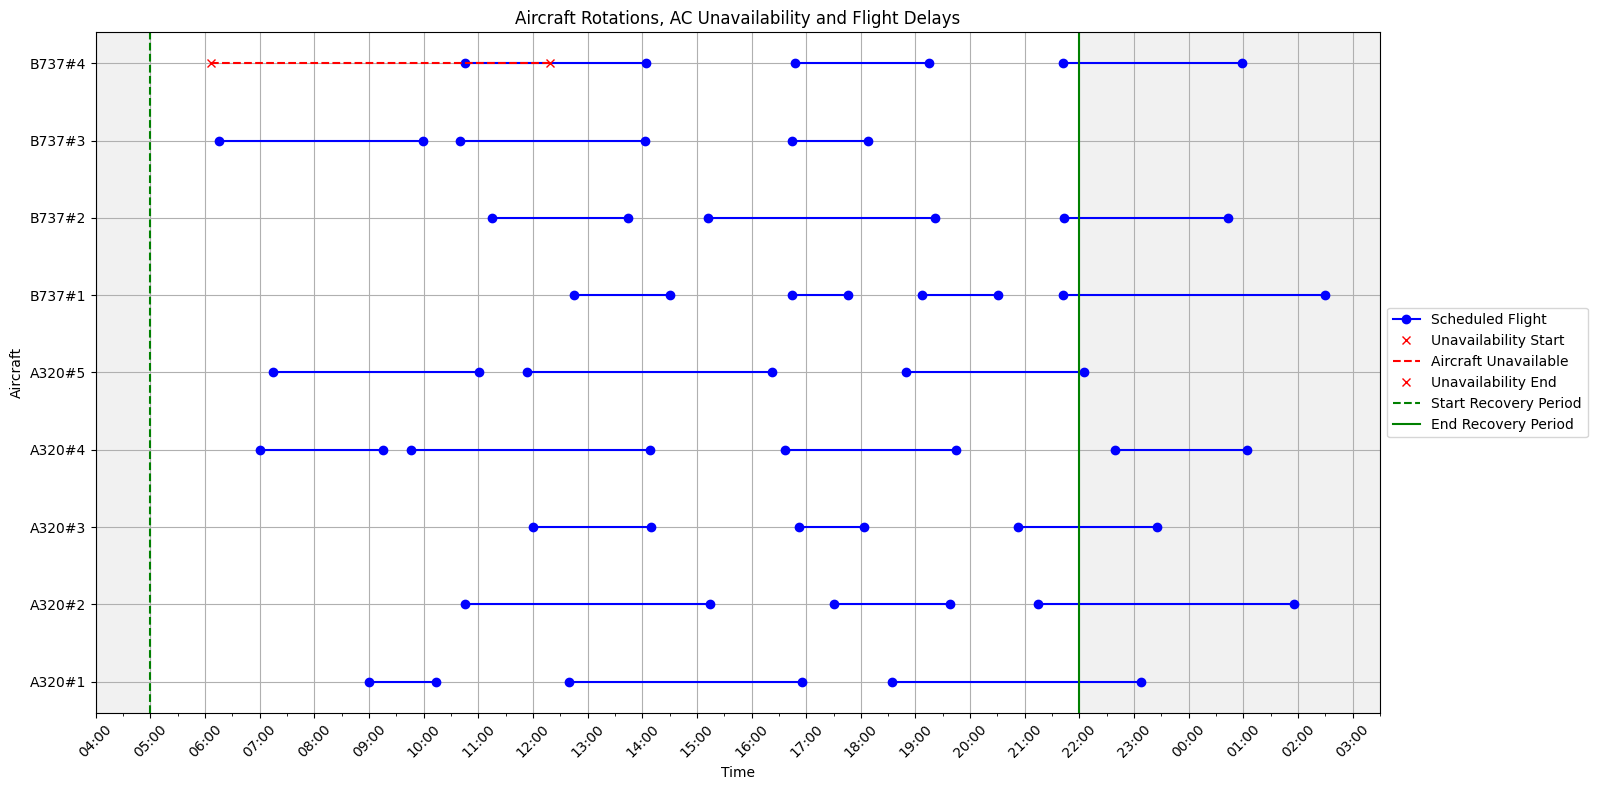

In [172]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from aircraft to index
aircraft_ids = sorted(list(set([rotation_info['Aircraft'] for rotation_info in rotations_dict.values()])), reverse=False)
aircraft_indices = {aircraft_id: index + 1 for index, aircraft_id in enumerate(aircraft_ids)}

# Plot each flight's schedule based on aircraft in blue
for rotation_id, rotation_info in rotations_dict.items():
    flight_id = rotation_id
    aircraft_id = rotation_info['Aircraft']
    
    if flight_id in flights_dict:
        flight_info = flights_dict[flight_id]
        dep_datetime_str = flight_info['DepTime']
        arr_datetime_str = flight_info['ArrTime']
        
        dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
        arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
        
        ax.plot([dep_datetime, arr_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='blue', marker='o', label='Scheduled Flight' if rotation_id == 1 else "")

# Plot disruptions in red for flight delays
if alt_flights_dict:
    for flight_id, disruption_info in alt_flights_dict.items():
        if flight_id in flights_dict:
            dep_datetime_str = flights_dict[flight_id]['DepTime']
            dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
            delay_duration = timedelta(minutes=disruption_info['Delay'])
            delayed_datetime = dep_datetime + delay_duration
            
            aircraft_id = rotations_dict[flight_id]['Aircraft']  # Get the aircraft ID for the flight
            ax.plot(dep_datetime, aircraft_indices[aircraft_id], 'X', color='red', label='Flight Delay Start' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot([dep_datetime, delayed_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='-', label='Flight Delay ' if flight_id == list(alt_flights_dict.keys())[0] else "")
            ax.plot(delayed_datetime, aircraft_indices[aircraft_id], '>', color='red', label='Flight Delay End' if flight_id == list(alt_flights_dict.keys())[0] else "")


# Plot unavailability in red for aircraft
if alt_aircraft_dict:
    for aircraft_id, unavailability_info in alt_aircraft_dict.items():
        start_date = unavailability_info['StartDate']
        start_time = unavailability_info['StartTime']
        end_date = unavailability_info['EndDate']
        end_time = unavailability_info['EndTime']
        
        unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
        unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')
        
        ax.plot(unavail_start_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability Start' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot([unavail_start_datetime, unavail_end_datetime], [aircraft_indices[aircraft_id], aircraft_indices[aircraft_id]], color='red', linestyle='--', label='Aircraft Unavailable' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")
        ax.plot(unavail_end_datetime, aircraft_indices[aircraft_id], 'rx', label='Unavailability End' if aircraft_id == list(alt_aircraft_dict.keys())[0] else "")

# Formatting the plot
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Recovery Period')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Recovery Period')

# Background outside recovery period slightly greyed out
ax.axvspan(end_datetime, latest_datetime + timedelta(hours=1), color='lightgrey', alpha=0.3)
ax.axvspan(earliest_datetime - timedelta(hours=1), start_datetime, color='lightgrey', alpha=0.3)


# Setting the y-ticks to be the indices with corresponding aircraft IDs as labels
plt.yticks(range(1, len(aircraft_ids) + 1), aircraft_ids)

plt.xlabel('Time')
plt.ylabel('Aircraft')
plt.title('Aircraft Rotations, AC Unavailability and Flight Delays')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Create legend on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


## Flights and airports unavailability

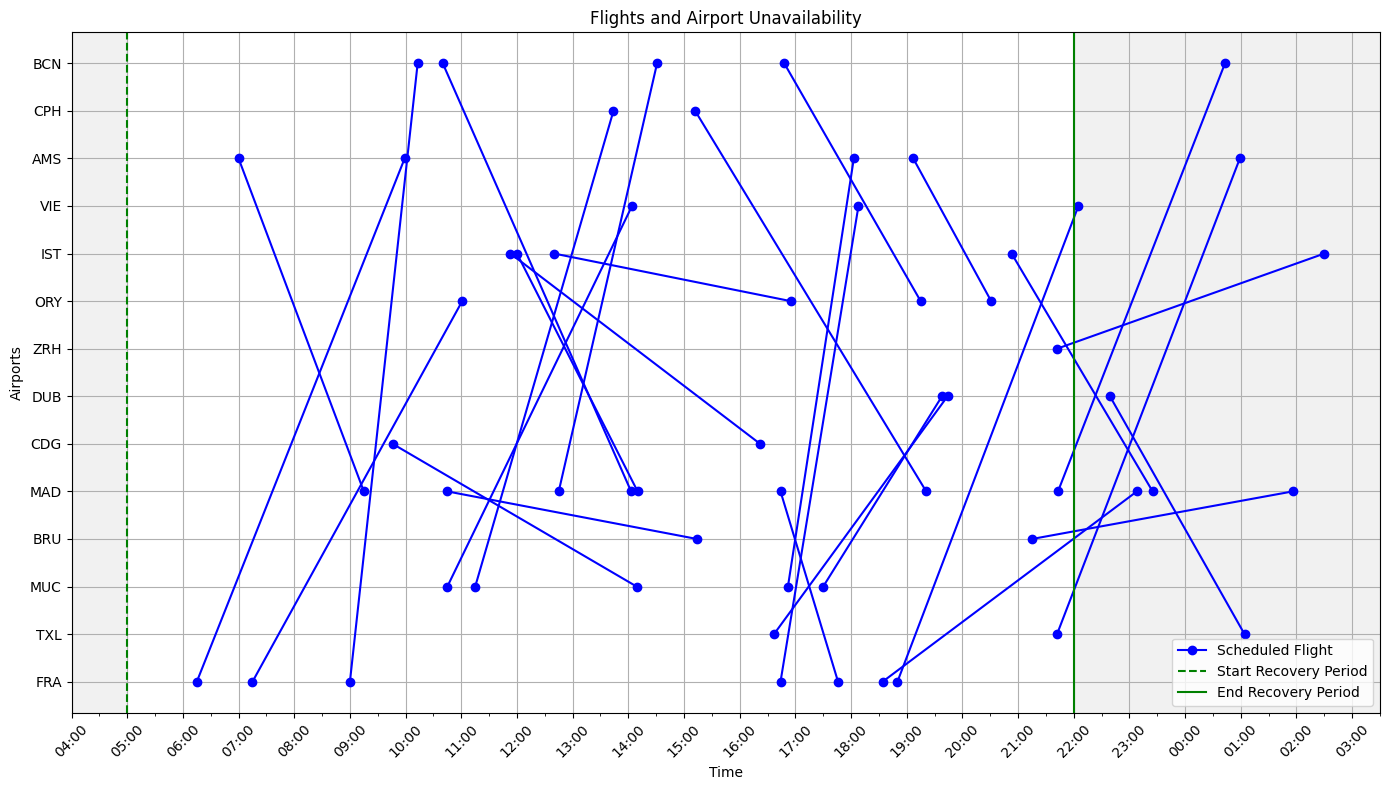

In [173]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Function to parse time strings, handling '+1' for next day times
def parse_time_with_day_offset(time_str, reference_date):
    if '+1' in time_str:
        time_str = time_str.replace('+1', '').strip()
        time_obj = datetime.strptime(time_str, '%H:%M')
        return datetime.combine(reference_date, time_obj.time()) + timedelta(days=1)
    else:
        return datetime.strptime(time_str, '%H:%M').replace(year=reference_date.year, month=reference_date.month, day=reference_date.day)

# Extracting start and end time from the recovery period
start_date = config_dict['RecoveryPeriod']['StartDate']
start_time = config_dict['RecoveryPeriod']['StartTime']
end_date = config_dict['RecoveryPeriod']['EndDate']
end_time = config_dict['RecoveryPeriod']['EndTime']

start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

# Determine the earliest and latest times from the flight data
earliest_datetime = start_datetime
latest_datetime = end_datetime

for flight_info in flights_dict.values():
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    if dep_datetime < earliest_datetime:
        earliest_datetime = dep_datetime
    if arr_datetime > latest_datetime:
        latest_datetime = arr_datetime

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create a mapping from airports to index
airports = list(set([flight_info['Orig'] for flight_info in flights_dict.values()] + [flight_info['Dest'] for flight_info in flights_dict.values()]))
airport_indices = {airport: index + 1 for index, airport in enumerate(airports)}

# Plot each flight's schedule based on airports in blue
for flight_id, flight_info in flights_dict.items():
    orig_airport = flight_info['Orig']
    dest_airport = flight_info['Dest']
    dep_datetime_str = flight_info['DepTime']
    arr_datetime_str = flight_info['ArrTime']
    
    dep_datetime = parse_time_with_day_offset(dep_datetime_str, start_datetime)
    arr_datetime = parse_time_with_day_offset(arr_datetime_str, dep_datetime)
    
    ax.plot([dep_datetime, arr_datetime], [airport_indices[orig_airport], airport_indices[dest_airport]], color='blue', marker='o', label='Scheduled Flight' if flight_id == 1 else "")

# Track which labels have been added to the legend
labels_added = set()

# Plot airport disruptions with different styles
if alt_airports_dict:
    for airport, disruptions in alt_airports_dict.items():
        for disruption_info in disruptions:
            start_date = disruption_info['StartDate']
            start_time = disruption_info['StartTime']
            end_date = disruption_info['EndDate']
            end_time = disruption_info['EndTime']
            dep_h = disruption_info['Dep/h']
            arr_h = disruption_info['Arr/h']
            
            unavail_start_datetime = datetime.strptime(start_date + ' ' + start_time, '%d/%m/%y %H:%M')
            unavail_end_datetime = datetime.strptime(end_date + ' ' + end_time, '%d/%m/%y %H:%M')

            if dep_h == 0 and arr_h == 0:
                linestyle = 'solid'
                linewidth = 3
                label = 'Completely Closed'
            elif dep_h == 0 or arr_h == 0:
                linestyle = 'solid'
                linewidth = 1
                label = 'Partially Closed (Dep/Arr)'
            else:
                linestyle = 'dashed'
                linewidth = 1
                label = 'Constrained'
            
            # Only add each label once
            if label not in labels_added:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth, label=label)
                labels_added.add(label)
            else:
                ax.plot([unavail_start_datetime, unavail_end_datetime], [airport_indices[airport], airport_indices[airport]], color='red', linestyle=linestyle, linewidth=linewidth)
            ax.plot(unavail_start_datetime, airport_indices[airport], 'rx')
            ax.plot(unavail_end_datetime, airport_indices[airport], 'rx')

# Formatting the plot
# xlim is earliest_datetime - 1 hour and latest_datetime + 1 hour
ax.set_xlim(earliest_datetime - timedelta(hours=1), latest_datetime + timedelta(hours=1))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.axvline(start_datetime, color='green', linestyle='--', label='Start Recovery Period')
ax.axvline(end_datetime, color='green', linestyle='-', label='End Recovery Period')

# Background outside recovery period slightly greyed out
ax.axvspan(end_datetime, latest_datetime + timedelta(hours=1), color='lightgrey', alpha=0.3)
ax.axvspan(earliest_datetime - timedelta(hours=1), start_datetime, color='lightgrey', alpha=0.3)

# Setting the y-ticks to be the indices with corresponding airport codes as labels
plt.yticks(range(1, len(airport_indices) + 1), airport_indices.keys())

plt.xlabel('Time')
plt.ylabel('Airports')
plt.title('Flights and Airport Unavailability')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()

plt.show()
